In [1]:
from IPython.core.display import HTML
css_file = './custom.css'
HTML(open(css_file, "r").read())

###### Content provided under a Creative Commons Attribution license, CC-BY 4.0; code under MIT License. (c)2014 [David I. Ketcheson](http://davidketcheson.info)

##### version 0.1 - May 2014

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

mpl.rcParams['font.size'] = 20

# Traffic flow

In this lesson, we'll investigate a conservation law that models the flow of traffic.  This model is sometimes referred to as the Lighthill-Whitham-Richards (or LWR) traffic model.

Recall the continuity equation from [Lesson 1](Lesson_01_Advection.ipynb):

$$q_t + (uq)_x = 0.$$

Now we will think of $q$ as the density of cars on a road, traveling with velocity $u$.  Note that we're not keeping track of the individual cars, but just of the average number of cars per unit length of road.  Thus $q=0$ represents an empty stretch of road, and we can choose the units so that $q=1$ represents bumper-to-bumper traffic.

We'll also choose units so that the speed limit is $u_\text{max}=1$, and assume that drivers never go faster than this (yeah, right!)  If we assume that drivers always travel at a single uniform velocity, we obtain once again the advection equation.  But we all know that's not accurate in practice -- cars go faster in light traffic and slower when there is congestion.  The simplest way to incorporate this effect is to make the velocity a linearly decreasing function of the density:

$$u(q) = 1 - q.$$

Notice that $u$ goes to zero as $q$ approaches the maximum density of 1, while $u$ goes to the maximum value of 1 as traffic density goes to zero.  Obviously, both $q$ and $u$ should always stay in the interval $[0,1]$.

![](./figures/LWR-Velocity.png)

Combining the two equations above, our conservation law says

$$q_t + (q (1-q))_x = 0.$$

The function $q(1-q)$ is the flux, or the rate of flow of cars.  Notice how the flux is zero when there are no cars and also when the road is completely full.  The maximum flow of traffic actually occurs when the road is half full:

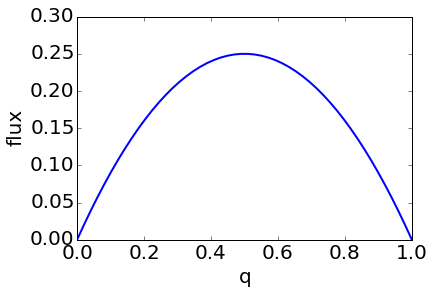

In [5]:
q = np.linspace(0,1)
f = q*(1.-q)
plt.plot(q, f, linewidth=2)
plt.ylim((0.0, 0.3))
plt.xlabel('q');
plt.ylabel('flux'); 

This equation is fundamentally different from the advection equation because the flux is **nonlinear**.  This fact will have dramatic consequences for both the behavior of solutions and our numerical methods.  But we can superficially make this equation look like the advection equation by using the chain rule to write

$$f(q)_x = f'(q) q_x = (1-2q)q_x.$$

Then we have

$$q_t + (1-2q)q_x = 0.$$

This is like the advection equation, but with a velocity $1-2q$ that depends on the density of cars.  The value $f'(q)=1-2q$ is referred to as the *characteristic speed*.  This characteristic speed is not the speed at which cars move (notice that it can even be negative!)  Rather, it is the speed at which *information* is transmitted along the road.

## Shock waves (traffic jams)

Let's use the *Lax-Friedrichs method* from [Lesson 1](Lesson_01_Advection.ipynb) to solve the LWR traffic model.

In [6]:
m = 400      # number of cells
dx = 1./m   # Size of 1 grid cell
x = np.arange(-dx/2, 1.+dx/2, dx)

t = 0. # Initial time
T = 0.5 # Final time
dt = 0.9 * dx  # Time step

Q = 0.9*np.exp(-100*(x-0.5)**2)
Qnew = np.empty(Q.shape)
QQ = [Q]

while t < T:

    Qnew[1:-1] = 0.5*(Q[:-2]+Q[2:]) - 0.5*dt/dx * (Q[2:]*(1-Q[2:])-Q[:-2]*(1-Q[:-2]))

    Q = Qnew.copy()
    Q[0] = Q[-2]
    Q[-1] = Q[1]
    t = t + dt
    QQ.append(Q)

To plot the solution, we'll use a function that you can find in the `util` directory of the course.

In [8]:
import sys
sys.path.append('./util')
from ianimate import ianimate

ianimate(x,QQ)

Starting from an initially smooth distribution of cars, we see that the solution evolves into something discontinuous!  What's going on?

Naturally, the cars in the low-density region behind the peak initially drive faster than the cars in the most congested region, ahead of them.  This leads to a steepening of the rear part of the traffic flow, and eventually there is a traffic jam: cars coming from the back have an open road, until suddenly they reach a highly congested area and must slam on the brakes.  Sound familiar?

### Exercises

1. Recall our discussion of the CFL condition for advection.  To apply the CFL condition to a nonlinear problem, we use the characteristic velocity (in this case $1-2q$) in place of the velocity $a$.  For this problem, how large can we take the time step without violating the CFL condition? **Answer**: CFL condition for the Lax-Friedrichs method is defined as

$$ \max |\lambda \frac{\Delta t}{\Delta x}| \leq 1, $$
where $\lambda$ is the maximum characteristic speed:
$$ \lambda = \max_{0 \leq x \leq 1} (1-2q(x, t))$$
for any given $t$. Therefore, strictly speaking, we must recompute $\lambda$ on each time layer. Here, instead of this, we bound CFL number by 0.9 instead of unity. **This bound works for this particular problem, but it may not work for some other problem.**

1. In the cell below, set things up to find out what happens when cars reach a red light.  Place the red light at $x=1$ and set $q=1$ in the interval $0.8<x<1$ near the light (the cars will be stopped, bumper to bumper there).  In the rest of the domain, set $q=0.2$, corresponding to light traffic.  In the ghost cell at the right boundary, set $q=1$; in the ghost cell at the left set $q=0.2$.  After you have computed the solution, check it against your inuition.  Does it make sense?

In [15]:
m = 2000      # number of cells
dx = 1./m   # Size of 1 grid cell
x = np.arange(-dx/2, 1.+dx/2, dx)

t = 0. # Initial time
T = 1.0 # Final time
dt = 0.9 * dx  # Time step

Q = np.empty_like(x)
Q[x<=0.8] = 0.2
Q[x>0.8] = 1.0

Qnew = np.empty_like(Q)
QQ = [Q]

i = 0
while t < T:
    Q[0] = 0.2
    Q[-1] = 1.0
    Qnew[1:-1] = 0.5*(Q[:-2]+Q[2:]) - 0.5*dt/dx * (Q[2:]*(1-Q[2:])-Q[:-2]*(1-Q[:-2]))

    Q = Qnew.copy()
    t = t + dt
    
    i += 1
    if i % 50 == 0:
        QQ.append(Q)
    
ianimate(x,QQ)

## Speed of a shock wave: the Rankine-Hugoniot conditions

In the second exercise above, you should have seen a shock wave (i.e., a discontinuity) that moves to the left as more and more cars pile up behind the red light.  How quickly does this discontinuity move to the left?

We can figure it out by putting an imaginary line at the location of the shock.  Let $q_l$ be the density of cars just to the left of the line, and let $q_r$ be the density of cars just to the right.  Imagine for a moment that the line is stationary.  Then the rate of cars reaching the line from the left is $f(q_l)$ and the rate of cars departing from the line to the right is $f(q_r)$.  If the line really were stationary, we would need to have $f(q_l)-f(q_r)=0$ to avoid cars accumulating at the line.

However, the shock is not stationary, so the line is moving.  Let $s$ be the speed of the shock.  Then as the line moves to the left, some cars that were to the left are now to the right of the line.  The rate of cars removed from the left is $s q_l$ and the rate of cars added on the right is $s q_r$.  So in order to avoid an accumulation of cars at the shock, these two effects need to be balanced:

$$f(q_l) - f(q_r) = s(q_l - q_r).$$

This condition is known as the **Rankine-Hugoniot condition**, and it holds for any shock wave in the solution of any hyperbolic system!

### Exercises

1. Use the Rankine-Hugoniot condition to determine the speed of the shock in the red-light example above.  Check it against the speed you observe.  Do they agree?  Try some other values for $q_r$ and $q_l$ and see if they agree. **Answer**: by using formula above, we find that $s = -0.2$. In the animation above we see that during time $T=1$ the shock wave travels to the left, and the final distance is 0.2. Hence, Lax--Friedrichs method propagate shock with correct speed.

2. Now see what happens to traffic when a light turns green.  Set $q=1$ for $0<x<1/2$ and $q=0$ for $1/2<x<1$.  What do you observe?  Does it agree with your real-life experience? **Answer**: we observe, that cars closest to the green light position (x = 0.5) start to move immediately. Information about green light propagates to the left, such that more and more cars start to move. The layer of cars moving becomes wider with time. Yes, this agrees with the real-life experience.

In [18]:
# Green light example
m = 2000      # number of cells
dx = 1./m   # Size of 1 grid cell
x = np.arange(-dx/2, 1.+dx/2, dx)

t = 0. # Initial time
T = 0.5 # Final time
dt = 0.9 * dx  # Time step

Q = np.empty_like(x)
Q[x<=0.5] = 1.0
Q[x>0.5] = 0.0

Qnew = np.empty_like(Q)
QQ = [Q]

i = 0
while t < T:
    Q[0] = 1.0
    Q[-1] = 0.0
    Qnew[1:-1] = 0.5*(Q[:-2]+Q[2:]) - 0.5*dt/dx * (Q[2:]*(1-Q[2:])-Q[:-2]*(1-Q[:-2]))

    Q = Qnew.copy()
    t = t + dt
    
    i += 1
    if i % 50 == 0:
        QQ.append(Q)
    
ianimate(x,QQ)

## Rarefaction waves

Why didn't we see a shock wave in the third exercise above?  Initially, the solution is discontinuous, but after time zero it becomes continuous.

Physically, the reason is clear: after the light turns green, the cars in front accelerate and spread out; then the cars behind them accelerate, and so forth.  This kind of expansion wave is referred to as a *rarefaction wave* by analogy to fluid dynamics.

How can we determine whether an initial discontinuity will lead to a shock or a rarefaction?
- Shocks appear in regions where characteristics overlap
- Rarefactions appear in regions where characteristics are spreading out

More precisely, if the value to the left of a shock is $q_l$ and the value to the right is $q_r$, then it must be that $f'(q_l)>f'(q_r)$.  In fact the shock speed must lie between these characteristic speeds:

$$f'(q_l) > s > f'(q_r).$$

We say that the characteristics *impinge* on the shock.  This is known as the *entropy condition*, because in fluid dynamics such a shock obeys the 2nd law of thermodynamics.

On the other hand, if $f'(q_l)< f'(q_r)$, then a rarefaction wave results.

## The Riemann problem

The problems you set up in the red and green light exercises above are examples of what is known as a Riemann problem.  A Riemann problem consists of  a hyperbolic conservation law, together with piecewise-constant initial data with a single point of discontinuity:

$$q(x,0) = \begin{cases} q_l & x < x_0 \\ q_r & x > x_0 \end{cases}$$

In fact, our entire finite volume method is built on approximately solving Riemann problems.  Since the solution is approximated by a constant function in each cell, a Riemann problem arises at each interface between two cells.  The upwind method for advection is based on exactly solving the Riemann problem to find the flux (of course, the Riemann problem for advection is extremely simple to solve).  The Lax-Friedrichs flux is based on approximating the solution to the Riemann problem.

For nonlinear systems of hyperbolic PDEs, like the Euler equations that we'll study in [Lesson 4](Lesson_04_Fluid_dynamics.ipynb), the solution of the Riemann problem can be quite complicated.  Computational methods for solving such systems are usually based on approximate Riemann solvers.  We won't go into the theory of Riemann problems or approximate Riemann solvers in this course.